In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import defaultdict
import argparse
import ast
import sys
import gzip
import csv
import pprint
import pandas as pd
import neet.sensitivity as ns
import neet.boolean as nn
from neet.boolean.examples import c_elegans

from scipy import stats
import scipy as sp
import community
from scipy.spatial.distance import pdist, squareform
from sklearn import datasets
from matplotlib import patches

from network_ei import *
from causal_emergence import *
from get_motifs import *

import matplotlib.patches as mpatches
from matplotlib import gridspec
from matplotlib._png import read_png
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

%matplotlib inline

In [2]:
def draw_adjacency_matrix(G, node_order=None, partitions=[], colors=[]):
    """
    - G is a netorkx graph
    - node_order (optional) is a list of nodes, where each node in G
          appears exactly once
    - partitions is a list of node lists, where each node in G appears
          in exactly one node list
    - colors is a list of strings indicating what color each
          partition should be
    If partitions is specified, the same number of colors needs to be
    specified.
    """
    adjacency_matrix = nx.to_numpy_matrix(G, dtype=np.bool, nodelist=node_order)
    N = G.number_of_nodes()

    fig = plt.figure(figsize=(12, 12)) # in inches
    plt.imshow(adjacency_matrix, cmap="Greys", interpolation="none")

    plt.xticks(np.arange(0, N, 1), []);
    plt.yticks(np.arange(0, N, 1), []);
    plt.xticks(np.arange(-.5, N-.5, 1), []);
    plt.yticks(np.arange(-.5, N-.5, 1), []);
    plt.grid(color='darkgrey', linestyle='-', linewidth=0.5)
    
    assert len(partitions) == len(colors)
    ax = plt.gca()
    for partition, color in zip(partitions, colors):
        current_idx = 0
        for module in partition:
            ax.add_patch(patches.Rectangle((current_idx, current_idx),
                                          len(module), # Width
                                          len(module), # Height
                                          facecolor="none",
                                          edgecolor=color,
                                          linewidth=3, alpha=0.8))
            current_idx += len(module)
            
def assignmentArray_to_lists(assignment_array):
    by_attribute_value = defaultdict(list)
    for node_index, attribute_value in enumerate(assignment_array.values()):
        by_attribute_value[attribute_value].append(node_index)
    return by_attribute_value.values()

In [3]:
colors = ["#91b43f","#7463cd","#54bc5b","#c560c7","#49925d","#cf4085","#49bfba","#cf4d2b","#6f8bce","#dd862f","#98558b",
"#c7a745","#dd85a8", "#777d35","#c64855","#9b5e2f","#e0906e"]

In [6]:
header_mapping = dict(zip(colHeaders, ['NetworkID', 'N', 'URL_paper', 'URL_data', 
                      'PaperCitation', 'PaperJournal', 'PaperTitle', 'PaperYear',
                      'System', 'InteractionsFromLit', 'InferredInteractionsFromLit', 
                      'InferredInteractionsFromExp', 'ExpPerformedForPape']))

In [7]:
# get metadata

with open('../data/network-metadata.csv', mode='r', errors='ignore') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    line_count = 0
    out_dict = {}
    for row in csv_reader:
        if line_count == 0:
            colHeaders = list(row)
            for i in colHeaders:
                out_dict[header_mapping[i]] = []
            line_count += 1
        else:
            count = 0
            vals = list(row.values())
            for i in out_dict.keys():
                if i=='N' or i=='PaperYear':
                    out_dict[i].append(int(vals[count]))
                else:
                    out_dict[i].append(vals[count])
                count += 1
            line_count += 1

In [8]:
out_dict['URL_data']

['https://cellcollective.org/#2681/cell-cycle-transcription-by-coupled-cdk-and-network-oscillators',
 'https://cellcollective.org/#2668/toll-pathway-of-drosophila-signaling-pathway',
 'https://cellcollective.org/#5731/metabolic-interactions-in-the-gut-microbiome',
 'https://cellcollective.org/#5128/lac-operon',
 'https://cellcollective.org/#6885:1/regulation-of-the-larabinose-operon-of-escherichia-coli/1',
 'https://cellcollective.org/#4837:1/arabidopsis-thaliana-cell-cycle/1',
 'https://cellcollective.org/#2136/cardiac-development',
 'https://cellcollective.org/#4790:1/fanconi-anemia-and-checkpoint-recovery/1',
 'https://cellcollective.org/#4706/predicting-variabilities-in-cardiac-gene',
 'https://cellcollective.org/#2699/bt474-breast-cell-line-shortterm-erbb-network',
 'https://cellcollective.org/#2700:1/hcc1954-breast-cell-line-shortterm-erbb-network/1',
 'https://cellcollective.org/#2202:1/neurotransmitter-signaling-pathway/1',
 'https://cellcollective.org/#2701:1/skbr3-breast-cell

In [9]:
# put the graph objects here
network_names = out_dict['NetworkID']
file_names = ["../data/walker/gml/"+i.replace(" ", "")+'.gml' for i in network_names]

out_dict['G'] = []
out_dict['EI'] = []
out_dict['eff'] = []
out_dict['determinism'] = []
out_dict['degeneracy'] = []
out_dict['coef_determinism'] = []
out_dict['coef_degeneracy'] = []
out_dict['sensitivity'] = []
out_dict['fn'] = file_names

for fn in out_dict['fn']:
    G = nx.read_gml(fn)
    print(fn)
    N = G.number_of_nodes()
    out_dict['G'].append(G)
    out_dict['EI'].append(get_ei(G))
    out_dict['determinism'].append(get_determinism(G))
    out_dict['degeneracy'].append(get_degeneracy(G))
    out_dict['eff'].append(get_ei(G)/np.log2(N))
    out_dict['coef_determinism'].append(get_determinism(G)/np.log2(N))
    out_dict['coef_degeneracy'].append(get_degeneracy(G)/np.log2(N))
    
#     W_out_test = get_Wout_full(G, p0=0)
#     net = nn.WTNetwork(W_out_test)
#     sens = ns.average_sensitivity(net)
#     out_dict['sensitivity'].append(sens)

../data/walker/gml/CellCycleTranscriptionByCoupledCDKAndNetworkOscillators.gml
../data/walker/gml/TollPathwayOfDrosophilaSignalingPathway.gml
../data/walker/gml/MetabolicInteractionsInTheGutMicrobiome.gml
../data/walker/gml/LacOperon.gml
../data/walker/gml/RegulationoftheL-arabinoseoperonofEscherichiacoli..gml
../data/walker/gml/ArabidopsisthalianaCellCycle.gml
../data/walker/gml/CardiacDevelopment.gml
../data/walker/gml/FanconiAnemiaAndCheckpointRecovery.gml
../data/walker/gml/PredictingVariabilitiesInCardiacGene.gml
../data/walker/gml/BT474BreastCellLineShort-termErbBNetwork.gml
../data/walker/gml/HCC1954BreastCellLineShort-termErbBNetwork.gml
../data/walker/gml/NeurotransmitterSignalingPathway.gml
../data/walker/gml/SKBR3BreastCellLineShort-termErbBNetwork.gml
../data/walker/gml/BodySegmentationInDrosophila2013.gml
../data/walker/gml/BuddingYeastCellCycle2009.gml
../data/walker/gml/CD4+TCellDifferentiationAndPlasticity.gml
../data/walker/gml/T-LGLSurvivalNetwork2011ReducedNetwork.gm

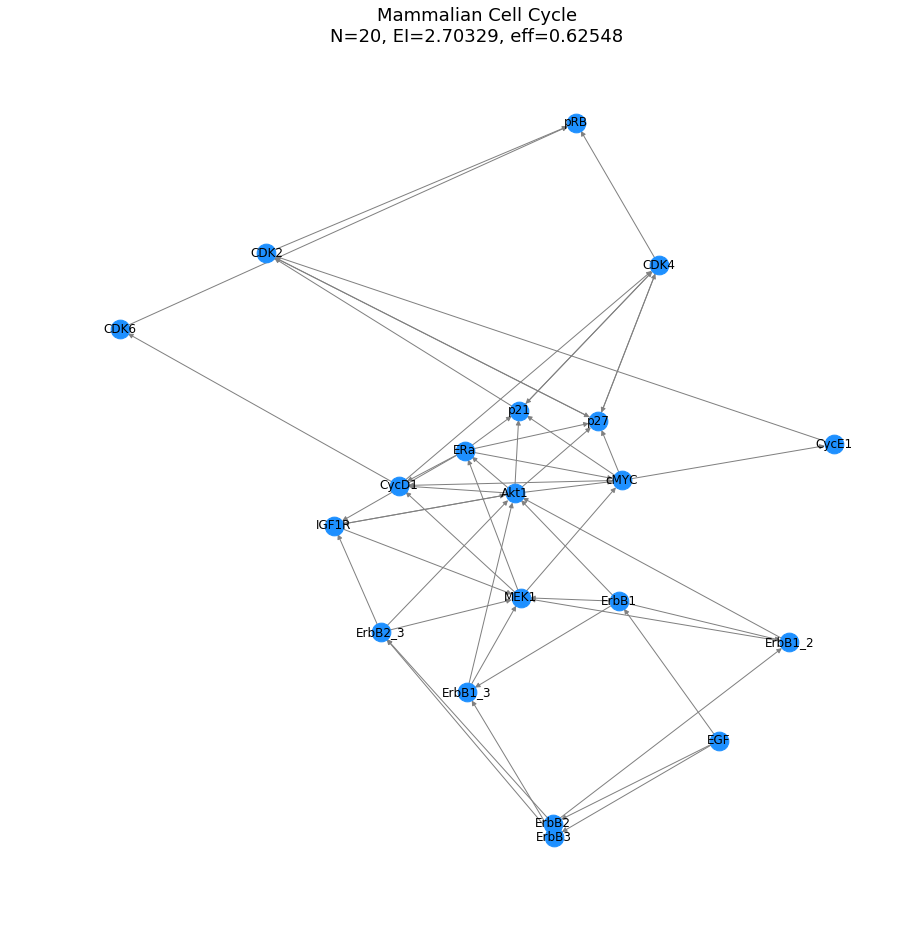

In [12]:
net_id = np.random.choice(list(range(len(out_dict['G']))))
plt.figure(figsize=(12,12))
pos = nx.kamada_kawai_layout(out_dict['G'][net_id])
nx.draw(out_dict['G'][net_id], pos=pos, node_size=350, node_color='dodgerblue', edge_width=1.5, edge_color='grey')
nx.draw_networkx_labels(out_dict['G'][net_id], pos=pos)
plt.title(out_dict['NetworkID'][net_id] + 
          "\nN=%i, EI=%.5f, eff=%.5f" %(out_dict['G'][net_id].number_of_nodes(), 
                                        out_dict['EI'][net_id], out_dict['eff'][net_id]), size=18)
plt.show()

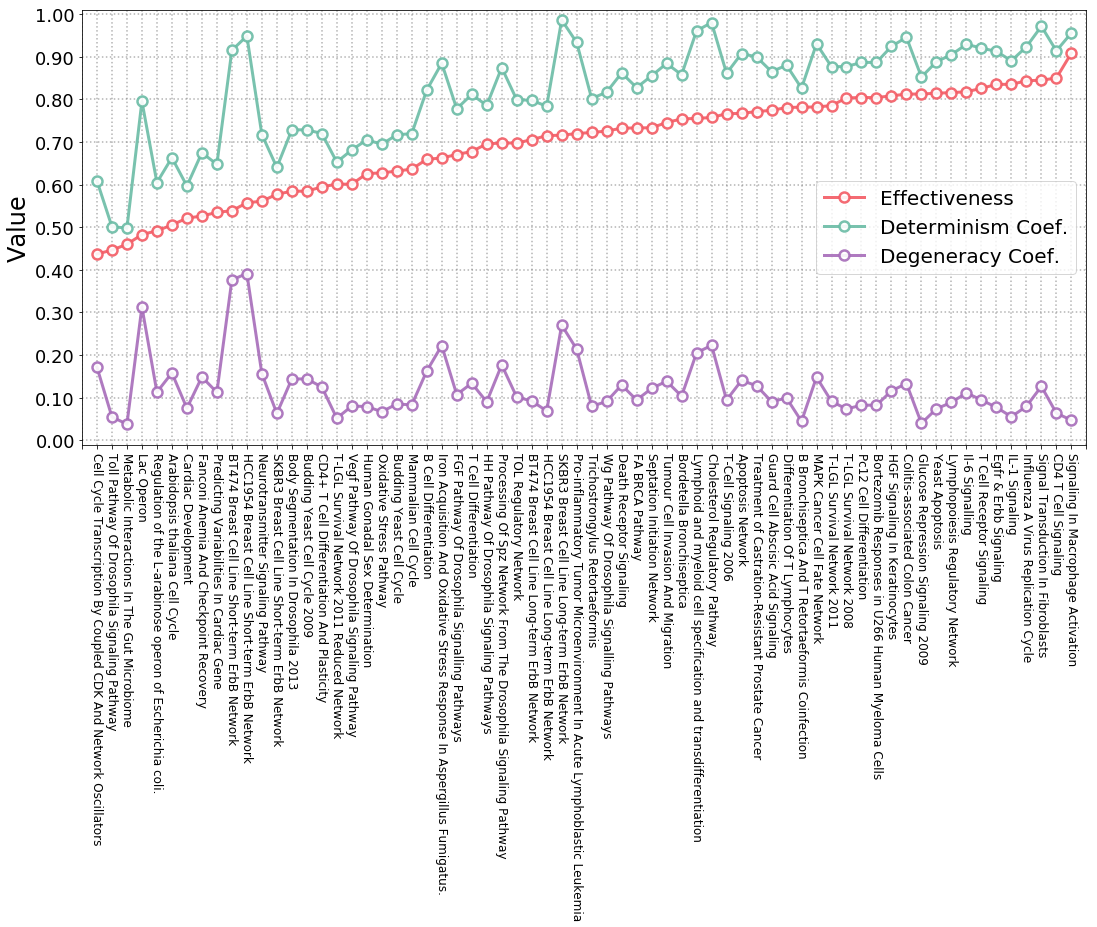

In [13]:
id_order = np.argsort(out_dict['eff'])
plt.figure(figsize=(18,8))

plt.plot(np.array(out_dict['eff'])[id_order],  marker='o', markersize=10, alpha=0.9,
         linestyle='-', linewidth=3.0,
         markeredgecolor='#f35b64', color='#f35b64', markeredgewidth=2.5, 
         markerfacecolor="w", label='Effectiveness')

plt.plot(np.array(out_dict['coef_determinism'])[id_order], marker='o', markersize=10, alpha=0.9, 
         linestyle='-', linewidth=3.0,
         markeredgecolor='#6abca5', color='#6abca5', markeredgewidth=2.5, 
         markerfacecolor="w", label='Determinism Coef.')

plt.plot(np.array(out_dict['coef_degeneracy'])[id_order],  marker='o', markersize=10, alpha=0.9, 
         linestyle='-', linewidth=3.0, 
         markeredgecolor='#a66cb9', color='#a66cb9', markeredgewidth=2.5, 
         markerfacecolor="w", label='Degeneracy Coef.')

xtix = np.linspace(-1,len(out_dict['NetworkID']),len(out_dict['NetworkID'])+2)
xticklist = [""]
for i in range(len(out_dict['NetworkID'])):
    xticklist.append(out_dict['NetworkID'][i])
xticklist.append("")

plt.xticks(xtix, xticklist, rotation=270, size=12)
plt.yticks(np.linspace(0,1,11), ["%.2f"%i for i in np.linspace(0,1,11)], size=18)
plt.grid(alpha=0.6, color='grey', linestyle=':', linewidth=1.5)
plt.xlim(-1,len(out_dict['NetworkID']))
plt.ylim(-0.01,1.01)
plt.ylabel('Value', size=24)
plt.legend(fontsize=20)

# plt.savefig("figs/pngs/Walker_66networks_eff.png", dpi=425, bbox_inches='tight')
# plt.savefig("figs/pdfs/Walker_66networks_eff.pdf", dpi=425, bbox_inches='tight')
plt.show()

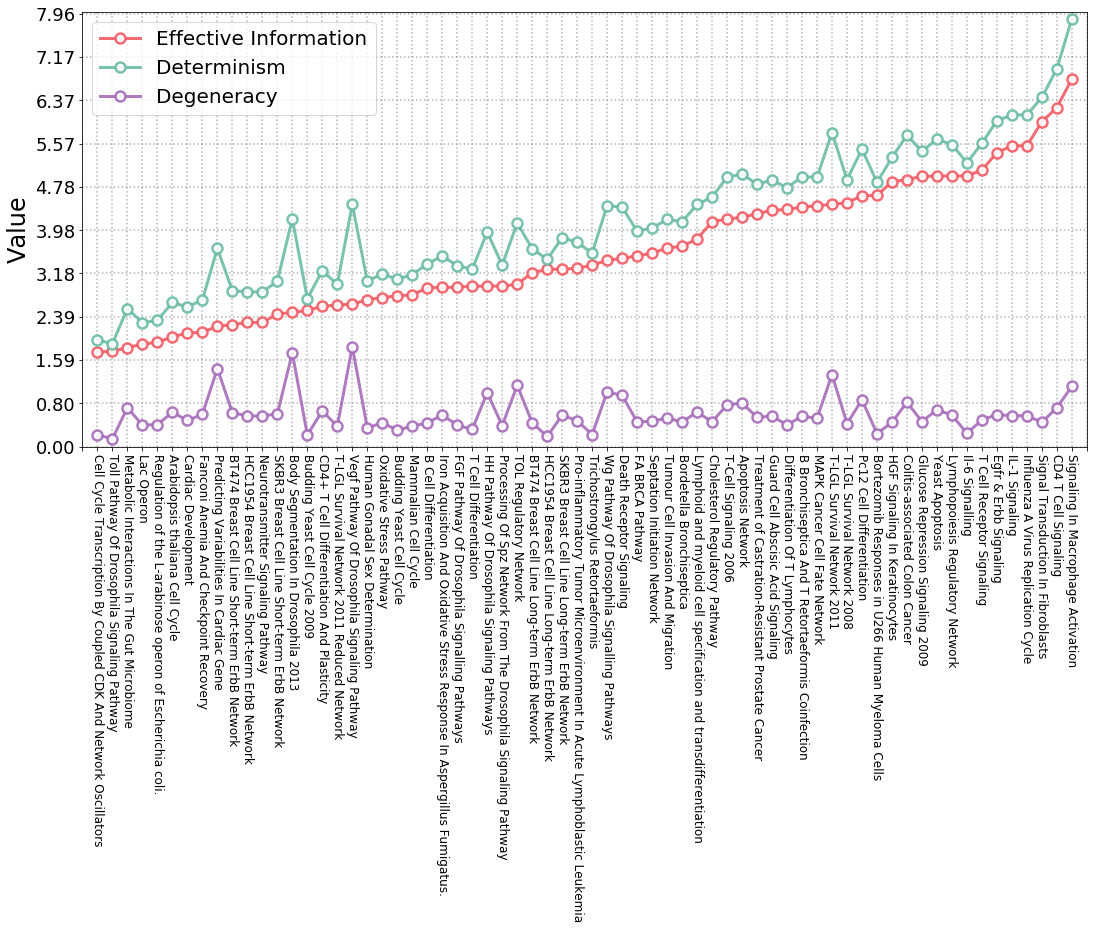

In [14]:
id_order = np.argsort(out_dict['EI'])
plt.figure(figsize=(18,8))

plt.plot(np.array(out_dict['EI'])[id_order],  marker='o', markersize=10, alpha=0.9,
         linestyle='-', linewidth=3.0,
         markeredgecolor='#f35b64', color='#f35b64', markeredgewidth=2.5, 
         markerfacecolor="w", label='Effective Information')

plt.plot(np.array(out_dict['determinism'])[id_order], marker='o', markersize=10, alpha=0.9, 
         linestyle='-', linewidth=3.0,
         markeredgecolor='#6abca5', color='#6abca5', markeredgewidth=2.5, 
         markerfacecolor="w", label='Determinism')

plt.plot(np.array(out_dict['degeneracy'])[id_order],  marker='o', markersize=10, alpha=0.9, 
         linestyle='-', linewidth=3.0, 
         markeredgecolor='#a66cb9', color='#a66cb9', markeredgewidth=2.5, 
         markerfacecolor="w", label='Degeneracy')

xtix = np.linspace(-1,len(out_dict['NetworkID']),len(out_dict['NetworkID'])+2)
xticklist = [""]
for i in range(len(out_dict['NetworkID'])):
    xticklist.append(out_dict['NetworkID'][i])
xticklist.append("")

plt.xticks(xtix, xticklist, rotation=270, size=12)
ytix = np.linspace(0,max(out_dict['EI'])+1.2,11)
plt.yticks(ytix, ["%.2f"%i for i in ytix], size=18)
plt.grid(alpha=0.6, color='grey', linestyle=':', linewidth=1.5)
plt.xlim(-1,len(out_dict['NetworkID']))
plt.ylim(0,8.0)
plt.ylabel('Value', size=24)
plt.legend(fontsize=20)

# plt.savefig("figs/pngs/Walker_66networks_EI.png", dpi=425, bbox_inches='tight')
# plt.savefig("figs/pdfs/Walker_66networks_EI.pdf", dpi=425, bbox_inches='tight')
plt.show()

In [76]:
out_dict['sensitivity'] = []
extras = [1.0, 0.9, 0.91, 0.87, 1.18, 0.95]
count = 0
for fn in out_dict['fn']:
    G = nx.read_gml(fn)
    print(fn)
    if  fn!='data/walker/T-LGLSurvivalNetwork2011.gml' and \
        fn!='data/walker/T-LGLSurvivalNetwork2008.gml' and \
        fn!='data/walker/Pc12CellDifferentiation.gml' and \
        fn!='data/walker/InfluenzaAVirusReplicationCycle.gml' and \
        fn!='data/walker/SignalTransductionInFibroblasts.gml' and \
        fn!='data/walker/SignalingInMacrophageActivation.gml':
        W_out_test = nx.to_numpy_array(G)
#         W_out_test = get_Wout_full(G, p0=0)
        net = nn.WTNetwork(W_out_test)
        sens = ns.average_sensitivity(net)
        out_dict['sensitivity'].append(sens)
    else:
        out_dict['sensitivity'].append(extras[count])
        count += 1

data/walker/CellCycleTranscriptionByCoupledCDKAndNetworkOscillators.gml
data/walker/TollPathwayOfDrosophilaSignalingPathway.gml
data/walker/MetabolicInteractionsInTheGutMicrobiome.gml
data/walker/LacOperon.gml
data/walker/RegulationoftheL-arabinoseoperonofEscherichiacoli..gml
data/walker/ArabidopsisthalianaCellCycle.gml
data/walker/CardiacDevelopment.gml
data/walker/FanconiAnemiaAndCheckpointRecovery.gml
data/walker/PredictingVariabilitiesInCardiacGene.gml
data/walker/BT474BreastCellLineShort-termErbBNetwork.gml
data/walker/HCC1954BreastCellLineShort-termErbBNetwork.gml
data/walker/NeurotransmitterSignalingPathway.gml
data/walker/SKBR3BreastCellLineShort-termErbBNetwork.gml
data/walker/BodySegmentationInDrosophila2013.gml
data/walker/BuddingYeastCellCycle2009.gml
data/walker/CD4+TCellDifferentiationAndPlasticity.gml
data/walker/T-LGLSurvivalNetwork2011ReducedNetwork.gml
data/walker/VegfPathwayOfDrosophilaSignalingPathway.gml
data/walker/HumanGonadalSexDetermination.gml
data/walker/Oxid

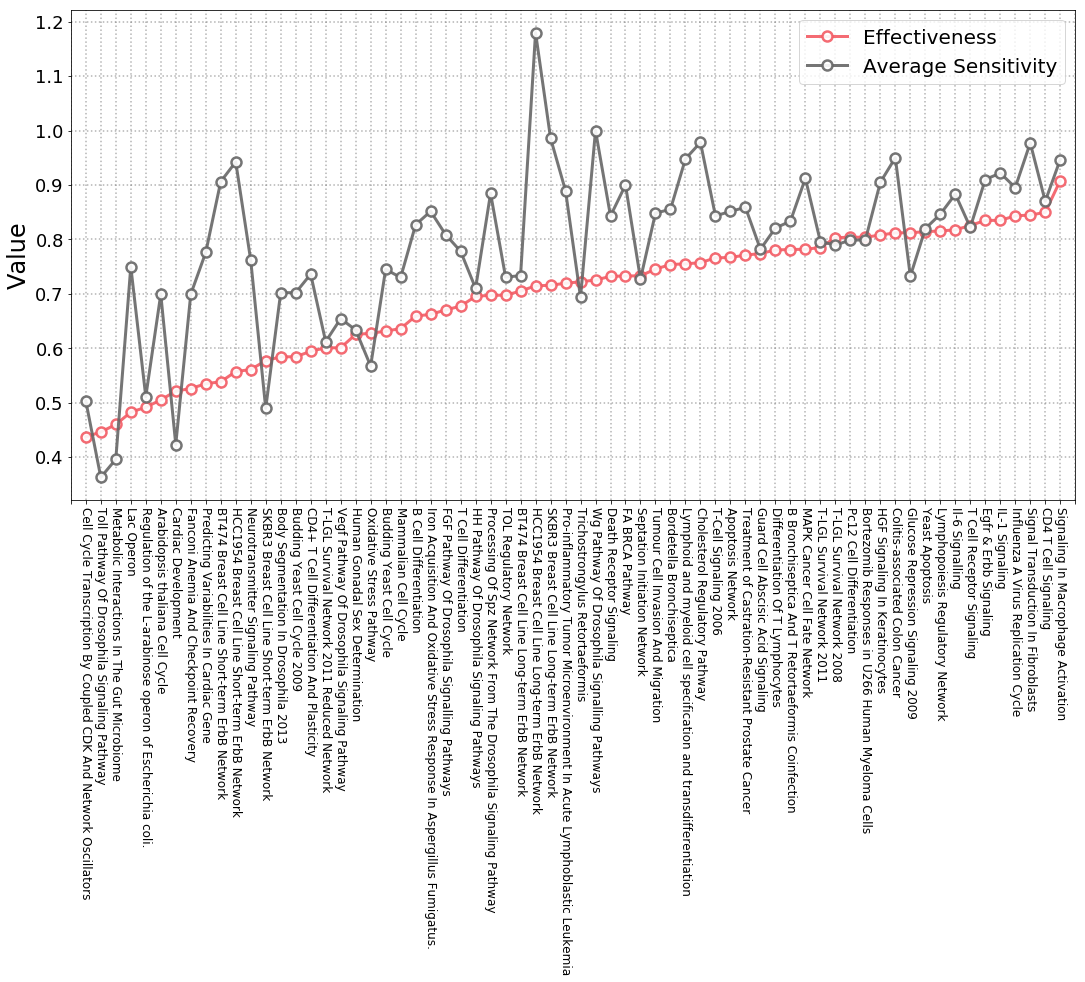

In [77]:
id_order = np.argsort(out_dict['eff'])
plt.figure(figsize=(18,9))

plt.plot(np.array(out_dict['eff'])[id_order],  marker='o', markersize=10, alpha=0.9,
         linestyle='-', linewidth=3.0,
         markeredgecolor='#f35b64', color='#f35b64', markeredgewidth=2.5, 
         markerfacecolor="w", label='Effectiveness')

plt.plot(np.array(out_dict['sensitivity'])[id_order],  marker='o', markersize=10, alpha=0.9,
         linestyle='-', linewidth=3.0,
         markeredgecolor='#666666', color='#666666', markeredgewidth=2.5, 
         markerfacecolor="w", label='Average Sensitivity')

xtix = np.linspace(-1,len(out_dict['NetworkID']),len(out_dict['NetworkID'])+2)
xticklist = [""]
for i in range(len(out_dict['NetworkID'])):
    xticklist.append(out_dict['NetworkID'][i])
xticklist.append("")

plt.xticks(xtix, xticklist, rotation=270, size=12)
# plt.yticks(np.linspace(0,2.5,11), ["%.2f"%i for i in np.linspace(0,2.5,11)], size=18)
plt.yticks(size=18)
plt.grid(alpha=0.6, color='grey', linestyle=':', linewidth=1.5)
plt.xlim(-1,len(out_dict['NetworkID']))
# plt.ylim(0.25,2.51)
plt.ylabel('Value', size=24)
plt.legend(fontsize=20)

# plt.savefig("figs/pngs/Walker_66networks_Sensitivity_vs_EI.png", dpi=425, bbox_inches='tight')
# plt.savefig("figs/pdfs/Walker_66networks_Sensitivity_vs_EI.pdf", dpi=425, bbox_inches='tight')
plt.show()

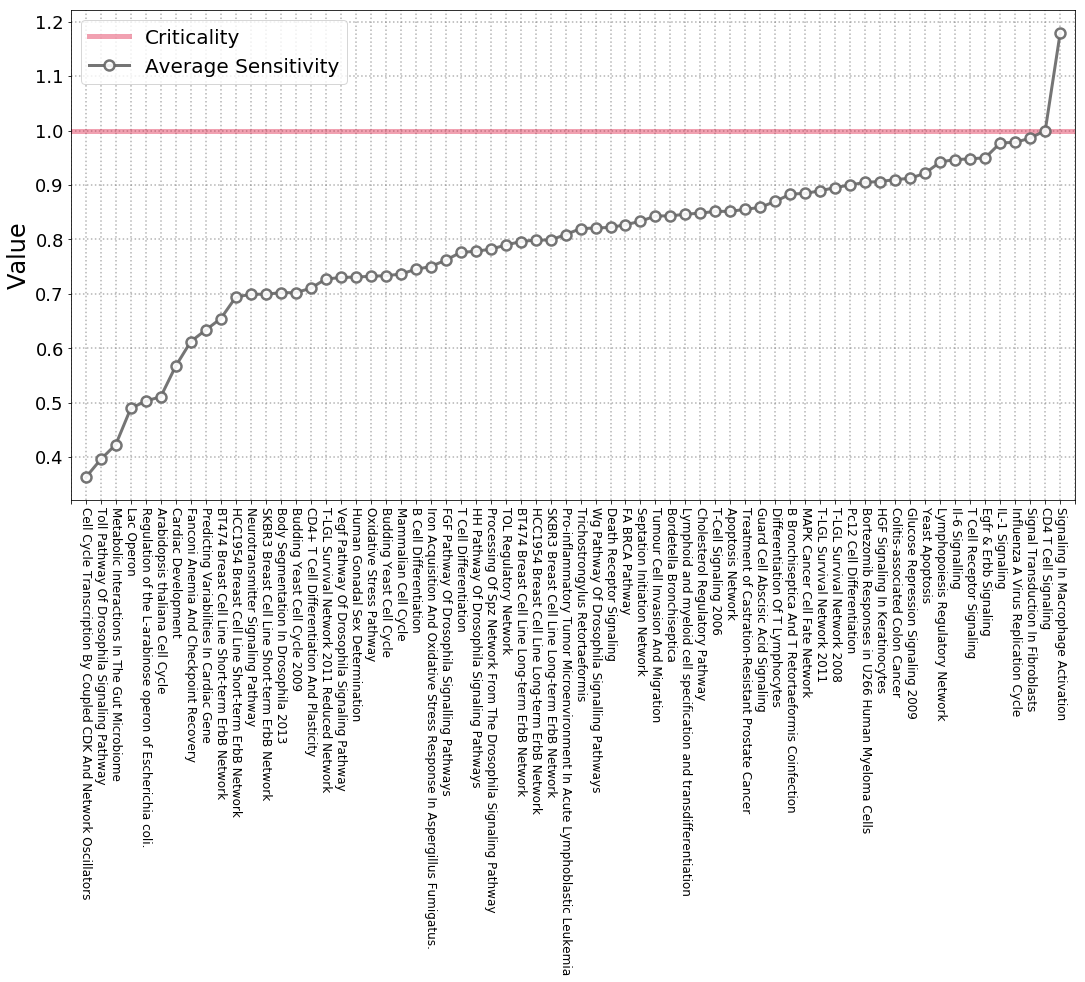

In [454]:
id_order = np.argsort(out_dict['sensitivity'])
plt.figure(figsize=(18,9))

# plt.plot(np.array(out_dict['eff'])[id_order],  marker='o', markersize=10, alpha=0.9,
#          linestyle='-', linewidth=3.0,
#          markeredgecolor='#f35b64', color='#f35b64', markeredgewidth=2.5, 
#          markerfacecolor="w", label='Effectiveness')

plt.plot([-4, 70], [1,1], marker='', alpha=0.4, linestyle='-', 
         linewidth=5.0, color='crimson', label='Criticality')
plt.plot(np.array(out_dict['sensitivity'])[id_order],  marker='o', markersize=10, alpha=0.9,
         linestyle='-', linewidth=3.0,
         markeredgecolor='#666666', color='#666666', markeredgewidth=2.5, 
         markerfacecolor="w", label='Average Sensitivity')

xtix = np.linspace(-1,len(out_dict['NetworkID']),len(out_dict['NetworkID'])+2)
xticklist = [""]
for i in range(len(out_dict['NetworkID'])):
    xticklist.append(out_dict['NetworkID'][i])
xticklist.append("")

plt.xticks(xtix, xticklist, rotation=270, size=12)
# plt.yticks(np.linspace(0,2.5,11), ["%.2f"%i for i in np.linspace(0,2.5,11)], size=18)
plt.yticks(size=18)
plt.grid(alpha=0.6, color='grey', linestyle=':', linewidth=1.5)
plt.xlim(-1,len(out_dict['NetworkID']))
# plt.ylim(0.25,2.51)
plt.ylabel('Value', size=24)
plt.legend(fontsize=20)

# plt.savefig("figs/pngs/Walker_66networks_Sensitivity.png", dpi=425, bbox_inches='tight')
# plt.savefig("figs/pdfs/Walker_66networks_Sensitivity.pdf", dpi=425, bbox_inches='tight')
# plt.savefig("figs/pngs/Walker_66networks_EI_vs_Sensitivity.png", dpi=425, bbox_inches='tight')
# plt.savefig("figs/pdfs/Walker_66networks_EI_vs_Sensitivity.pdf", dpi=425, bbox_inches='tight')
plt.show()

In [ ]:
def scatter_plot_with_correlation_line(x, y, graph_filepath):
    # Scatter plot
    plt.scatter(x, y)

    # Add correlation line
    axes = plt.gca()
    m, b = np.polyfit(x, y, 1)
    X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
    plt.plot(X_plot, m*X_plot + b, '-')

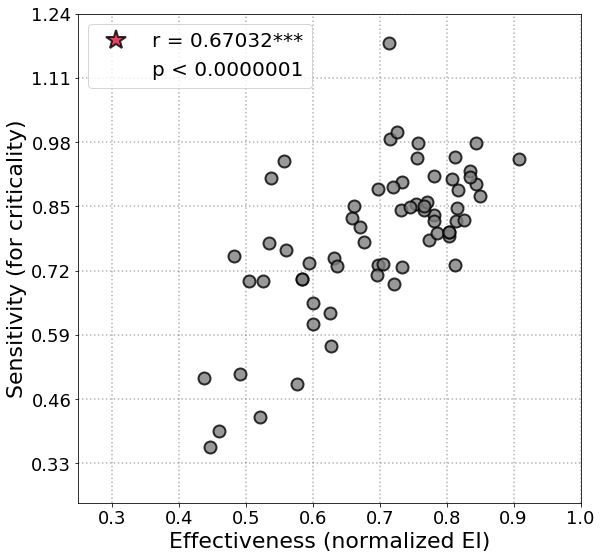

In [156]:
plt.figure(figsize=(9,9))

plt.plot(np.array(out_dict['eff']), np.array(out_dict['sensitivity']), marker='o', markersize=12, alpha=0.8,
         linestyle='', markeredgecolor='k', markeredgewidth=2.0,  markerfacecolor="grey")

xtix = np.linspace(-1,len(out_dict['NetworkID']),len(out_dict['NetworkID'])+2)
xticklist = [""]
for i in range(len(out_dict['NetworkID'])):
    xticklist.append(out_dict['NetworkID'][i])
xticklist.append("")

plt.xticks(np.linspace(0.2,1.0,9), np.round(np.linspace(0.2,1.0,9), 2), size=18)
plt.yticks(np.linspace(0.2,1.5,11), np.round(np.linspace(0.2,1.5,11), 2), size=18)
plt.grid(alpha=0.6, color='grey', linestyle=':', linewidth=1.5)
plt.ylabel('Sensitivity (for criticality)', size=22)
plt.xlabel('Effectiveness (normalized EI)', size=22)
plt.ylim(0.25, 1.24)
plt.xlim(0.25, 1.0)
x = np.array(out_dict['eff'])
y = np.array(out_dict['sensitivity'])
r, p = sp.stats.pearsonr(x, y)

plt.plot([100],[100],label='r = %.5f***'%r, markersize=20, alpha=0.8,
         marker='*',linestyle='',markeredgecolor='k', markeredgewidth=2.0,  markerfacecolor="crimson")
plt.plot([100],[100],label='p < %.6f1'%p, 
         marker='',linestyle='',markeredgecolor='k', markeredgewidth=2.0,  markerfacecolor="grey")

plt.legend(fontsize=20)

# plt.savefig("figs/pngs/Walker_66networks_Eff_corr_Sensitivity.png", dpi=425, bbox_inches='tight')
# plt.savefig("figs/pdfs/Walker_66networks_Eff_corr_Sensitivity.pdf", dpi=425, bbox_inches='tight')
plt.show()

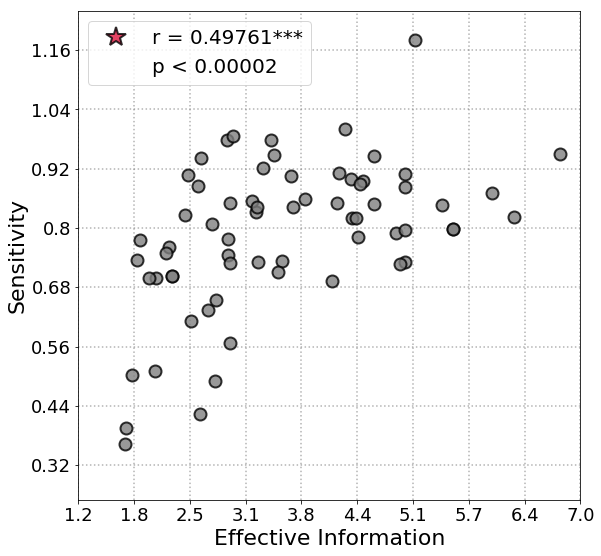

In [167]:
plt.figure(figsize=(9,9))

plt.plot(np.array(out_dict['EI']), np.array(out_dict['sensitivity']), marker='o', markersize=12, alpha=0.8,
         linestyle='', markeredgecolor='k', markeredgewidth=2.0,  markerfacecolor="grey")

xtix = np.linspace(-1,len(out_dict['NetworkID']),len(out_dict['NetworkID'])+2)
xticklist = [""]
for i in range(len(out_dict['NetworkID'])):
    xticklist.append(out_dict['NetworkID'][i])
xticklist.append("")

plt.xticks(np.linspace(1.2,7.0,10), np.round(np.linspace(1.2,7.0,10), 1), size=18)
plt.yticks(np.linspace(0.2,1.4,11), np.round(np.linspace(0.2,1.4,11), 2), size=18)
plt.grid(alpha=0.6, color='grey', linestyle=':', linewidth=1.5)
plt.ylabel('Sensitivity', size=22)
plt.xlabel('Effective Information', size=22)
plt.ylim(0.25, 1.24)
plt.xlim(1.20, 7.0)
x = np.array(out_dict['EI'])
y = np.array(out_dict['sensitivity'])
r, p = sp.stats.pearsonr(x, y)

plt.plot([100],[100],label='r = %.5f***'%r, markersize=20, alpha=0.8,
         marker='*',linestyle='',markeredgecolor='k', markeredgewidth=2.0,  markerfacecolor="crimson")
plt.plot([100],[100],label='p < %.5f'%p, 
         marker='',linestyle='',markeredgecolor='k', markeredgewidth=2.0,  markerfacecolor="grey")

plt.legend(fontsize=20)

# plt.savefig("figs/pngs/Walker_66networks_EI_corr_Sensitivity.png", dpi=425, bbox_inches='tight')
# plt.savefig("figs/pdfs/Walker_66networks_EI_corr_Sensitivity.pdf", dpi=425, bbox_inches='tight')
plt.show()

_______________________

In [270]:
# # October 26th
# def get_macro(G, macro_mapping, p0=0):
#     """
#     Given an input graph and a micro-to-macro mapping, output a macro transition matrix.
#     - param G: current micro graph
#     - param macro_mapping: a dictionary with {micro_node:macro_node}
#     - param p0: smallest probability
    
#     - output: Macro, a macro-level transition-probability matrix
#     """
#     # might have to assert node_labels to be integers
#     G = prepare_network(G,p0=p0)
#     micro_network_size = G.number_of_nodes()
#     micro_Wout = get_Wout_full(G, p0)
#     micro_nodes = np.unique(list(macro_mapping.keys()))
#     nodes_in_macro_network = np.unique(list(macro_mapping.values()))

#     macro_network_size = len(nodes_in_macro_network)
#     macro_nodes = nodes_in_macro_network[nodes_in_macro_network > micro_network_size-1]
#     n_macro = len(macro_nodes)
    
#     if n_macro==0:
#         return micro_Wout
    
#     micro_to_macro_list = []
#     for macro_i in range(n_macro):
#         micro_in_macro_i = [k for k,v in macro_mapping.items() if v==macro_nodes[macro_i]]
#         micro_to_macro_list.append(micro_in_macro_i)
    
#     # get new rows
#     macro_row_list = []
#     for macro_i in micro_to_macro_list:
#         macro_row_list.append(sum(micro_Wout[macro_i,:]))
    
#     macro_rows = np.vstack(macro_row_list)

#     # get new cols
#     macro_col_list = []
#     for macro_i in micro_to_macro_list:
#         macro_col_list.append(sum(micro_Wout.T[macro_i,:]))

#     macro_cols = np.vstack(macro_col_list)    
#     macro_cols = macro_cols.T
    
#     # get stubby diagonal square in the bottom right
#     macro_bottom_right = np.zeros((n_macro,n_macro))
#     for macro_i in range(n_macro):
#         for macro_j in range(n_macro):
#             macro_bottom_right[macro_i, macro_j] = sum(macro_row_list[macro_i][micro_to_macro_list[macro_j]])

#     # put them all together in a matrix that is too big
#     too_big_macro = np.block([[micro_Wout, macro_cols], [macro_rows, macro_bottom_right]])
    
#     macro_out = too_big_macro[nodes_in_macro_network,:][:,nodes_in_macro_network]
    
#     Macro = macro_out / macro_out.sum(axis=1)[:, np.newaxis]
    
    
#     return Macro

# # PRINT VERSION, WORKS
# def causal_emergence(G, p0=0, thresh=0.0001):
#     """
#     Given a micro-scale network, iterate through possible macro-groupings and look for causal emergence.
#     - param G: a networkx object or adjacency matrix or TPM
#     - param p0: smallest probability
    
#     - output Gm: a macro-scale network object with higher EI than G
#     """
#     G = prepare_network(G, p0) # makes the network weighted, directed if it's not already
#     current_ei = get_ei(G, p0)
#     micro_nodes_left = list(G.nodes())
#     micros_that_have_been_macroed = []
#     macro_mapping = dict(zip(micro_nodes_left, micro_nodes_left))    
#     print("Starting with this tpm:\n",np.round(get_Wout_full(G,p0), 4))
#     print("\nSearch started... current_ei = %.4f"%current_ei)

#     np.random.shuffle(micro_nodes_left)
#     for node_i in micro_nodes_left:
#         print("...",node_i,"...","macro size =",len(np.unique(list(macro_mapping.values()))))

#         neighbors_i = set(list(G.successors(node_i))).union(set(list(G.predecessors(node_i))))
#         for node_j in neighbors_i:
#             neighbors_j = set(list(G.successors(node_j))).union(set(list(G.predecessors(node_j))))
#             neighbors_i = neighbors_j.union(neighbors_i)
#         macros_to_check = [i for i in list(neighbors_i) if i!=node_i]
#         queue = macros_to_check.copy()

#         node_i_macro = macro_mapping[node_i]
#         if node_i_macro == node_i:
#             node_i_macro = max(list(macro_mapping.values()))+1
            
#         while len(queue) > 0:
#             np.random.shuffle(queue)
#             possible_macro = queue.pop()

#             possible_mapping = macro_mapping.copy()
#             possible_mapping[node_i]         = node_i_macro
#             possible_mapping[possible_macro] = node_i_macro

#             MACRO = get_macro(G, possible_mapping, p0)
#             macro_ei = get_ei(MACRO, p0)
#             Gm = prepare_network(MACRO, p0=p0)

#             if macro_ei - current_ei > thresh:
#             # keep adding shit in the queue to the current_macro_grouping, once you get anything 
#             # with a little extra EI
#                 current_ei = macro_ei
#                 macro_mapping = possible_mapping
#                 print("just found successful macro grouping... current_ei = %.4f"%current_ei)
#                 micros_that_have_been_macroed.append(node_i)
#                 micros_that_have_been_macroed.append(possible_macro)
#                 micros_that_have_been_macroed = list(set(micros_that_have_been_macroed))

#                 nodes_in_macro_i = [k for k, v in macro_mapping.items() if v==node_i_macro]
                
#                 for new_micro_in_macro_i in nodes_in_macro_i:
#                     neighbors_Mi = set(list(
#                         G.successors(new_micro_in_macro_i))).\
#                         union(set(list(G.predecessors(new_micro_in_macro_i))))
                        
#                     for node_Mj in neighbors_Mi:
#                         if node_Mj not in queue and node_Mj != node_i:
#                             queue.append(node_Mj)
    
#     try:
#         MACRO = get_macro(G, macro_mapping, p0)
#         Gm = prepare_network(MACRO, p0=p0)
#         return Gm, macro_mapping, G
#     except:
#         return [], macro_mapping, G
# October 26th
def get_macro(G, macro_mapping, p0=0):
    """
    Given an input graph and a micro-to-macro mapping, output a macro transition matrix.
    - param G: current micro graph
    - param macro_mapping: a dictionary with {micro_node:macro_node}
    - param p0: smallest probability
    
    - output: Macro, a macro-level transition-probability matrix
    """
    # might have to assert node_labels to be integers
    G = prepare_network(G,p0=p0)
    micro_network_size = G.number_of_nodes()
    micro_Wout = get_Wout_full(G, p0)
    micro_nodes = np.unique(list(macro_mapping.keys()))
    nodes_in_macro_network = np.unique(list(macro_mapping.values()))

    macro_network_size = len(nodes_in_macro_network)
    macro_nodes = nodes_in_macro_network[nodes_in_macro_network > micro_network_size-1]
    n_macro = len(macro_nodes)
    
    if n_macro==0:
        return micro_Wout
    
    micro_to_macro_list = []
    for macro_i in range(n_macro):
        micro_in_macro_i = [k for k,v in macro_mapping.items() if v==macro_nodes[macro_i]]
        micro_to_macro_list.append(micro_in_macro_i)
    
    # get new rows
    macro_row_list = []
    for macro_i in micro_to_macro_list:
        macro_row_list.append(sum(micro_Wout[macro_i,:]))
    
    macro_rows = np.vstack(macro_row_list)

    # get new cols
    macro_col_list = []
    for macro_i in micro_to_macro_list:
        macro_col_list.append(sum(micro_Wout.T[macro_i,:]))

    macro_cols = np.vstack(macro_col_list)    
    macro_cols = macro_cols.T
    
    # get stubby diagonal square in the bottom right
    macro_bottom_right = np.zeros((n_macro,n_macro))
    for macro_i in range(n_macro):
        for macro_j in range(n_macro):
            macro_bottom_right[macro_i, macro_j] = sum(macro_row_list[macro_i][micro_to_macro_list[macro_j]])

    # put them all together in a matrix that is too big
    too_big_macro = np.block([[micro_Wout, macro_cols], [macro_rows, macro_bottom_right]])
    
    macro_out = too_big_macro[nodes_in_macro_network,:][:,nodes_in_macro_network]
    
    Macro = macro_out / macro_out.sum(axis=1)[:, np.newaxis]
    
    
    return Macro

# PRINT VERSION, WORKS
def causal_emergence(G, p0=0, thresh=0.0001):
    """
    Given a micro-scale network, iterate through possible macro-groupings and look for causal emergence.
    - param G: a networkx object or adjacency matrix or TPM
    - param p0: smallest probability
    
    - output Gm: a macro-scale network object with higher EI than G
    """
    G = prepare_network(G, p0) # makes the network weighted, directed if it's not already
    current_ei = get_ei(G, p0)
    micro_nodes_left = list(G.nodes())
    micros_that_have_been_macroed = []
    macro_mapping = dict(zip(micro_nodes_left, micro_nodes_left))    
    print("Starting with this tpm:\n",np.round(get_Wout_full(G,p0), 4))
    print("\nSearch started... current_ei = %.4f"%current_ei)
    count = 0
    np.random.shuffle(micro_nodes_left)
    for node_i in micro_nodes_left:
        count += 1
        print("%03i"%count, "...",node_i,"...","macro size =",len(np.unique(list(macro_mapping.values()))))

        neighbors_i = set(list(G.successors(node_i))).union(set(list(G.predecessors(node_i))))
        for node_j in neighbors_i:
            neighbors_j = set(list(G.successors(node_j))).union(set(list(G.predecessors(node_j))))
            neighbors_i = neighbors_j.union(neighbors_i)
        macros_to_check = [i for i in list(neighbors_i) if i!=node_i]
        queue = macros_to_check.copy()

        node_i_macro = macro_mapping[node_i]
        if node_i_macro == node_i:
            node_i_macro = max(list(macro_mapping.values()))+1
            
        while len(queue) > 0:
            np.random.shuffle(queue)
            possible_macro = queue.pop()

            possible_mapping = macro_mapping.copy()
            possible_mapping[node_i]         = node_i_macro
            possible_mapping[possible_macro] = node_i_macro

            try:
                MACRO = get_macro(G, possible_mapping, p0)
                macro_ei = get_ei(MACRO, p0)
                Gm = prepare_network(MACRO, p0=p0)
            except:
                continue

            MACRO = get_macro(G, possible_mapping, p0)
            macro_ei = get_ei(MACRO, p0)
            Gm = prepare_network(MACRO, p0=p0)

            if macro_ei - current_ei > thresh:
            # keep adding shit in the queue to the current_macro_grouping, once you get anything 
            # with a little extra EI
                current_ei = macro_ei
                macro_mapping = possible_mapping
                print("just found successful macro grouping... current_ei = %.4f"%current_ei)
                micros_that_have_been_macroed.append(node_i)
                micros_that_have_been_macroed.append(possible_macro)
                micros_that_have_been_macroed = list(set(micros_that_have_been_macroed))

                nodes_in_macro_i = [k for k, v in macro_mapping.items() if v==node_i_macro]
                
                for new_micro_in_macro_i in nodes_in_macro_i:
                    neighbors_Mi = set(list(
                        G.successors(new_micro_in_macro_i))).\
                        union(set(list(G.predecessors(new_micro_in_macro_i))))
                        
                    for node_Mj in neighbors_Mi:
                        if node_Mj not in queue and node_Mj != node_i:
                            queue.append(node_Mj)
    
    try:
        MACRO = get_macro(G, macro_mapping, p0)
        Gm = prepare_network(MACRO, p0=p0)
        return Gm, macro_mapping, G
    except:
        return [], macro_mapping, G

In [9]:
import neet as neet
# G = nx.read_pajek('../data/breast_cellcycle.net')

In [10]:
# mouse_cortical_7B = nn.examples.mouse_cortical_7B
# G = neet.synchronous.transition_graph(mouse_cortical_7B)
# print("Mouse Cortical 7B: \n\tN =",G.number_of_nodes())
# s = [G.subgraph(c) for c in nx.weakly_connected_components(G)]
# print("\tSubgraph sizes =",[len(s[i]) for i in range(len(s))])
# Gname = 'Mouse Cortical 7B'

# mouse_cortical_7C = nn.examples.mouse_cortical_7C
# G = neet.synchronous.transition_graph(mouse_cortical_7C)
# print("\nMouse Cortical 7C: \n\tN =",G.number_of_nodes())
# s = [G.subgraph(c) for c in nx.weakly_connected_components(G)]
# print("\tSubgraph sizes =",[len(s[i]) for i in range(len(s))])
# Gname = 'Mouse Cortical 7C'

# s_cerevisiae = nn.examples.s_cerevisiae
# G = neet.synchronous.transition_graph(s_cerevisiae)
# print("\ns_cerevisiae: \n\tN =",G.number_of_nodes())
# s = [G.subgraph(c) for c in nx.weakly_connected_components(G)]
# print("\tSubgraph sizes =",[len(s[i]) for i in range(len(s))])
# Gname = 'Saccharomyces cerevisiae gene network'

s_pombe = nn.examples.s_pombe
G = neet.synchronous.transition_graph(s_pombe)
Gname = 'Schizosaccharomyces pombe gene network'
print("%s: \n\tN = %i"%(Gname,G.number_of_nodes()))
s = [G.subgraph(c) for c in nx.weakly_connected_components(G)]
print("\tSubgraph sizes =",[len(s[i]) for i in range(len(s))])
GG = nx.convert_node_labels_to_integers(G)

Schizosaccharomyces pombe gene network: 
	N = 512
	Subgraph sizes = [378, 2, 2, 2, 104, 6, 6, 2, 2, 2, 2, 2, 2]


In [11]:
GG = nx.convert_node_labels_to_integers(G)
nc = colors[1]

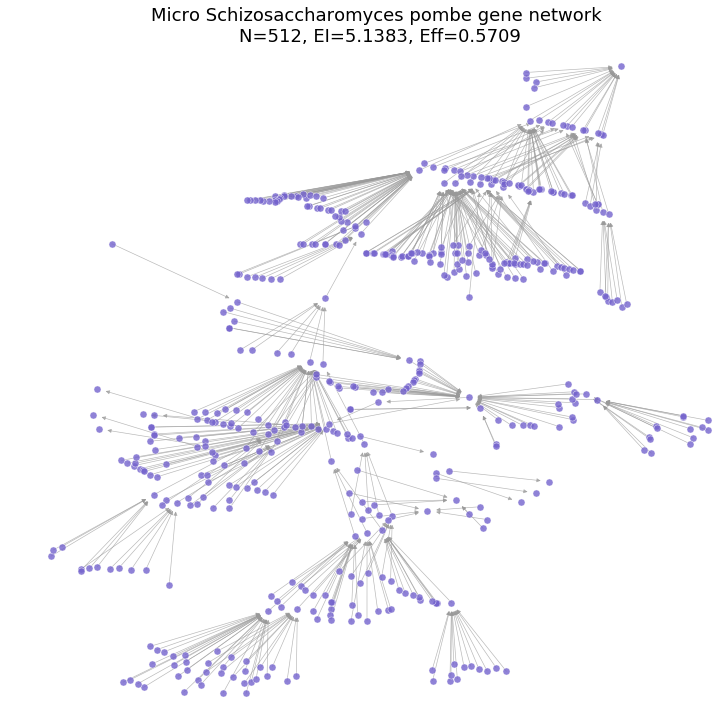

In [12]:
plt.figure(figsize=(12,12))

pos1 = nx.kamada_kawai_layout(GG)
pos = nx.spring_layout(GG, pos=pos1, iterations=5)

nx.draw_networkx_nodes(GG, pos, node_color=nc, node_size=50, edgecolors='w', linewidths=0.5, alpha=0.8)
nx.draw_networkx_edges(GG, pos, edge_color='#999999', width=0.65, alpha=0.7, arrowsize=8)

plt.axis('off')
plt.title("Micro %s \nN=%i, EI=%.4f, Eff=%.4f"%(Gname, GG.number_of_nodes(),
                                    get_ei(GG, p0=0), 
                                    get_ei(GG, p0=0)/np.log2(GG.number_of_nodes())), size=18)

plt.xlim(min(list(zip(*list(pos.values())))[0])-0.01, max(list(zip(*list(pos.values())))[0])+0.01)
plt.ylim(min(list(zip(*list(pos.values())))[1])-0.02, max(list(zip(*list(pos.values())))[1])+0.06)

# plt.savefig("../figs/pngs/S_pombe_micro_network.png", dpi=425, bbox_inches='tight')#, facecolor='#262626')
# plt.savefig("../figs/pdfs/S_pombe_micro_network.pdf", bbox_inches='tight')#, facecolor='#262626')
pos_micro = pos
micro_pos = pos

plt.show()

In [311]:
neet_graph = nn.examples.c_elegans#s_pombe
G = neet.synchronous.transition_graph(neet_graph)
Gname = 'C elegans gene network'
print("%s: \n\tN = %i"%(Gname,G.number_of_nodes()))
s = [G.subgraph(c) for c in nx.weakly_connected_components(G)]
print("\tSubgraph sizes =",[len(s[i]) for i in range(len(s))])
GG = nx.convert_node_labels_to_integers(G)

C elegans gene network: 
	N = 256
	Subgraph sizes = [4, 219, 12, 5, 16]


In [312]:
p0=0
mG, mapping, GG = causal_emergence(GG, p0)

Starting with this tpm:
 [[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]

Search started... current_ei = 5.4822
001 ... 193 ... macro size = 256
002 ... 35 ... macro size = 256
003 ... 75 ... macro size = 256
just found successful macro grouping... current_ei = 5.4856
just found successful macro grouping... current_ei = 5.4885
just found successful macro grouping... current_ei = 5.4935
just found successful macro grouping... current_ei = 5.5017
just found successful macro grouping... current_ei = 5.5046
just found successful macro grouping... current_ei = 5.5135
just found successful macro grouping... current_ei = 5.5156
just found successful macro grouping... current_ei = 5.5247
just found successful macro grouping... current_ei = 5.5341
just found successful macro grouping... current_ei = 5.5434
just found successful macro grouping...

just found successful macro grouping... current_ei = 5.8549
just found successful macro grouping... current_ei = 5.8589
073 ... 59 ... macro size = 164
just found successful macro grouping... current_ei = 5.8591
just found successful macro grouping... current_ei = 5.8593
just found successful macro grouping... current_ei = 5.8598
just found successful macro grouping... current_ei = 5.8606
074 ... 120 ... macro size = 164
just found successful macro grouping... current_ei = 5.8625
just found successful macro grouping... current_ei = 5.8638
075 ... 54 ... macro size = 162
076 ... 99 ... macro size = 162
077 ... 168 ... macro size = 162
078 ... 113 ... macro size = 162
just found successful macro grouping... current_ei = 5.8660
079 ... 195 ... macro size = 161
080 ... 159 ... macro size = 161
081 ... 242 ... macro size = 161
082 ... 9 ... macro size = 161
083 ... 58 ... macro size = 161
just found successful macro grouping... current_ei = 5.8681
084 ... 123 ... macro size = 160
085 ... 50

In [315]:
ss = list(neet_graph.state_space())
mw = get_macro_weights(neet_graph, mapping)
print("Micro sensitivity c elegans:",ns.average_sensitivity(neet_graph))
print("Macro sensitivity c elegans:",ns.average_sensitivity(neet_graph, states=ss, weights=list(mw.values())))
print("Micro effectiveness c elegans:",get_ei(GG, p0)/np.log2(GG.number_of_nodes()))
print("Macro effectiveness c elegans:",get_ei(mG, p0)/np.log2(mG.number_of_nodes()))

Micro sensitivity c elegans: 1.265625
Macro sensitivity c elegans: 1.31881864955
Micro effectiveness c elegans: 0.685271863897
Macro effectiveness c elegans: 0.807362508748


In [303]:
def get_macro_weights(NeetGraph, mapping):
    """Returns a weighting after causal emergence for neet."""
    ss = list(NeetGraph.state_space())
    microstate_mapping = dict(zip(list(range(len(ss))), ss))
    microstate_weights = []
    for micro_num, micro_state in microstate_mapping.items():
        if micro_num in list(mapping.keys()):
            macros = mapping[micro_num]
            other_micros_leading_to_macro = [microstate_mapping[i] for i in microstate_mapping.keys() \
                                             if mapping[i]==macros]
            microstate_weights.append(1/len(other_micros_leading_to_macro))
        else:
            microstate_weights.append(1)

    return dict(zip(list(range(len(ss))), microstate_weights))  

In [272]:
macro_cols = []
macro_pos  = {}
for micro, macro in mapping.items():
    if micro==macro:
        macro_cols.append(colors[1])
        macro_pos[micro] = micro_pos[micro] 
    else:
        macro_cols.append(colors[2])
        micros_for_macro_pos = np.array([micro_pos[i] for i in micro_pos.keys() if mapping[i]==macro])
        macro_pos[macro] = np.average(micros_for_macro_pos, axis=0)

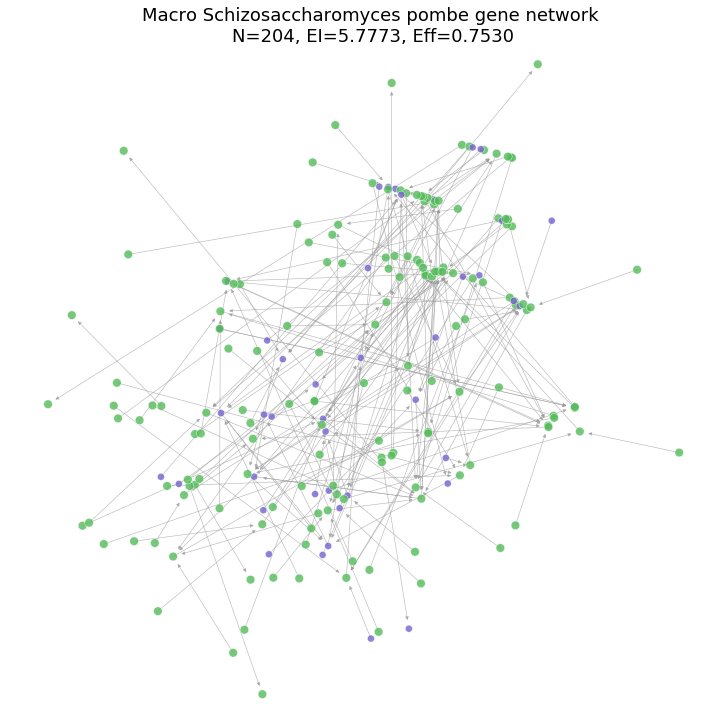

In [280]:
plt.figure(figsize=(12,12))

pos = macro_pos
sizes = [75 if i!=macro_cols[-1] else 50 for i in macro_cols]
mG = nx.relabel_nodes(mG, dict(zip(list(mG.nodes()), list(macro_pos.keys()))))
fixnodes = list(set([i for i in list(pos.keys()) if i in list(micro_pos.keys())]))
pos = nx.spring_layout(mG, pos=pos, fixed=fixnodes, iterations=3)

nx.draw_networkx_nodes(mG, pos, node_color=macro_cols, node_size=sizes, edgecolors='w', linewidths=0.5, alpha=0.8)
nx.draw_networkx_edges(mG, pos, edge_color='#999999', width=0.6, alpha=0.7, arrowsize=7)

plt.axis('off')
plt.title("Macro %s \nN=%i, EI=%.4f, Eff=%.4f"%(Gname, mG.number_of_nodes(),
                                    get_ei(mG, p0=0), 
                                    get_ei(mG, p0=0)/np.log2(mG.number_of_nodes())), size=18)

plt.xlim(min(list(zip(*list(pos.values())))[0])-0.02, max(list(zip(*list(pos.values())))[0])+0.06)
plt.ylim(min(list(zip(*list(pos.values())))[1])-0.02, max(list(zip(*list(pos.values())))[1])+0.06)

# plt.savefig("../figs/pngs/S_pombe_macro_network.png", dpi=425, bbox_inches='tight')#, facecolor='#262626')
# plt.savefig("../figs/pdfs/S_pombe_macro_network.pdf", bbox_inches='tight')#, facecolor='#262626')

plt.show()

In [251]:
s_pombe = nn.examples.s_pombe
G = neet.synchronous.transition_graph(s_pombe)
print("\ns_pombe: \n\tN =",G.number_of_nodes())
s = [G.subgraph(c) for c in nx.weakly_connected_components(G)]
print("\tSubgraph sizes =",[len(s[i]) for i in range(len(s))])
Gname = 'Saccharomyces pombe gene network'


s_pombe: 
	N = 512
	Subgraph sizes = [378, 2, 2, 2, 104, 6, 6, 2, 2, 2, 2, 2, 2]


In [252]:
ns.average_sensitivity(s_pombe)

0.95138888888888884

In [13]:
# GG = nx.DiGraph(s[1])
G = nx.convert_node_labels_to_integers(G)
# partition = community.best_partition(nx.to_undirected(GG))
# comms = np.array([partition[i] for i in GG.nodes()])
# nc = [colors[i] for i in comms]
nc = colors[1]

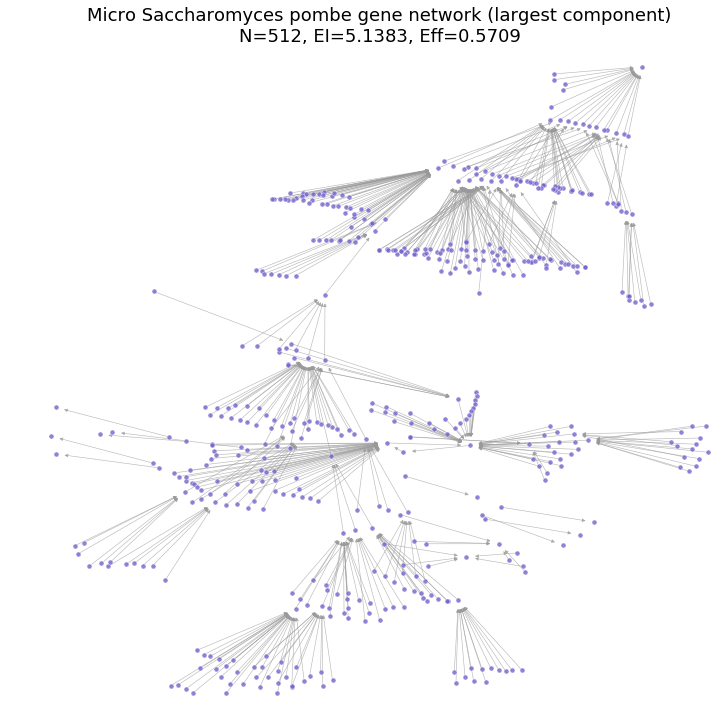

In [254]:
plt.figure(figsize=(12,12))

pos1 = nx.kamada_kawai_layout(G)
pos = nx.spring_layout(G, pos=pos1, iterations=7)

nx.draw_networkx_nodes(G, pos, node_color=nc, node_size=25, edgecolors='w', linewidths=0.5, alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color='#999999', width=0.6, alpha=0.7, arrowsize=7)

plt.axis('off')
plt.title("Micro %s (largest component)\nN=%i, EI=%.4f, Eff=%.4f"%(Gname, G.number_of_nodes(),
                                    get_ei(G, p0=0), 
                                    get_ei(G, p0=0)/np.log2(G.number_of_nodes())), size=18)

plt.xlim(min(list(zip(*list(pos.values())))[0])-0.01, max(list(zip(*list(pos.values())))[0])+0.01)
plt.ylim(min(list(zip(*list(pos.values())))[1])-0.02, max(list(zip(*list(pos.values())))[1])+0.06)

# plt.savefig("../figs/pngs/S_cerevisiae_micro_network.png", dpi=425, bbox_inches='tight')#, facecolor='#262626')
# plt.savefig("../figs/pdfs/S_cerevisiae_micro_network.pdf", bbox_inches='tight')#, facecolor='#262626')

plt.show()

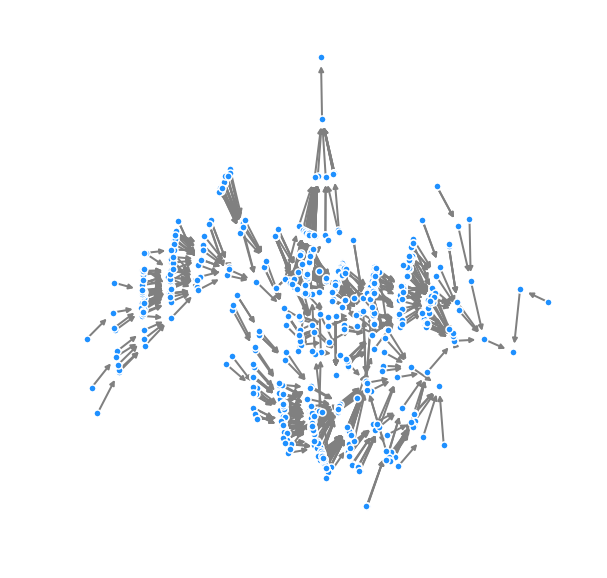

In [166]:
mG2 = mG.copy()
G6 = nx.DiGraph()
new_add = mG.copy()
H = s[0].copy()
H = nx.compose(H, s[2])
H = nx.compose(H, s[3])
H = nx.compose(H, s[4])
H = nx.compose(H, s[5])
H = nx.compose(H, s[6])
maxHind = max(list(H.nodes()))
new_add = nx.relabel_nodes(new_add, dict(zip(list(new_add.nodes()), [i+maxHind for i in list(new_add.nodes())])))
H = nx.compose(H, new_add)
print(get_ei(neet.synchronous.transition_graph(s_cerevisiae), p0=p0))
print(get_ei(H,p0))

plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(H)
nx.draw_networkx_nodes(H, pos, node_size=50, 
                       linewidths=1.5, node_color='dodgerblue').set_edgecolor('w')
nx.draw_networkx_edges(H, pos, edge_color='grey', width=1.0)
plt.axis('off')
plt.show()

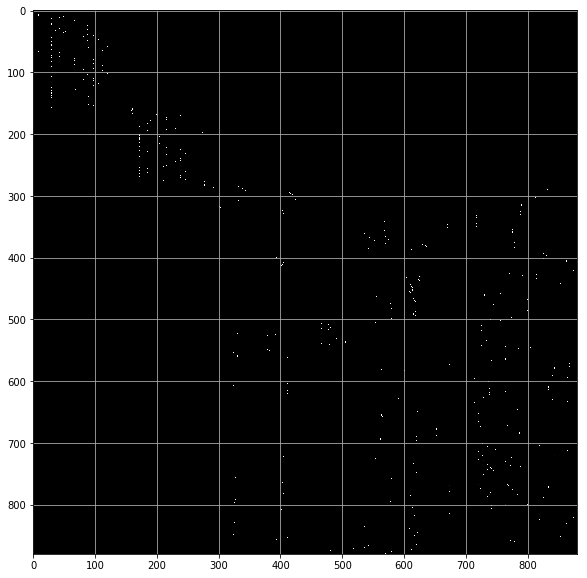

In [175]:
plt.figure(figsize=(10,10))
plt.imshow(nx.to_numpy_array(H), cmap=plt.cm.Greys_r)
plt.grid()
plt.show()

In [46]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(80,37))
pos_G = nx.circular_layout(G)
nx.draw(G, pos=pos_G, node_size=10, node_color='dodgerblue', edge_width=0.1, edge_color='grey', ax=ax0)
# nx.draw_networkx_labels(G, pos=pos_G)
ax0.set_title("Myeloid Micro Network: EI=%.4f, N=%i"%(get_ei(G, p0=0), G.number_of_nodes()), size=40)

pos_m = nx.circular_layout(mG)
nx.draw(mG, pos=pos_m, node_size=10, node_color='crimson', edge_width=0.1, edge_color='grey', ax=ax1)
# nx.draw_networkx_labels(mG, pos=pos_m)
ax1.set_title("Myeloid Macro Network: EI=%.4f, N=%i"%(get_ei(mG, p0=0), mG.number_of_nodes()), size=40)

# plt.savefig("../figs/pngs/Myeloid_CE.png", dpi=300, bbox_inches='tight')#, facecolor='#262626')
# plt.savefig("../figs/pdfs/Myeloid_CE.pdf", bbox_inches='tight')#, facecolor='#262626')
plt.show()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [47]:
myelin_mapping = mapping

In [48]:
# np.save("../data/myelin.npy", myelin_mapping)

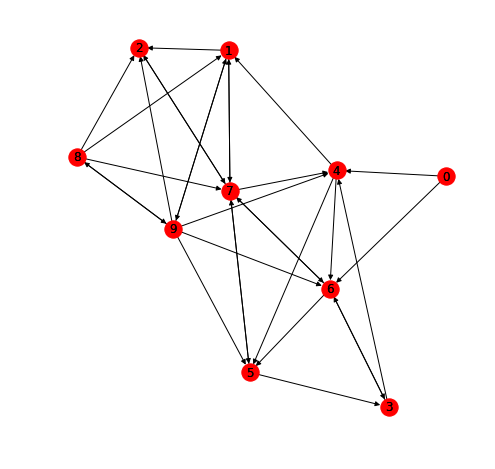

Adjacency: 0.5359375
W_out: 0.5359375
Boolean: 1.01875


In [77]:
# Apoptosis Network
tlg = nn.LogicNetwork.read_logic('../data/walker/logic/mammalian_expressions.ALL.txt', 
             external_nodes_path='../data/walker/logic/mammalian_external_components.ALL.txt')
tlG = nn.LogicNetwork.to_networkx_graph(tlg)
plt.figure(figsize=(8,8))
pos = nx.kamada_kawai_layout(tlG)
nx.draw_networkx(tlG, pos)
nx.draw_networkx_labels(tlG, pos)
plt.axis('off')
plt.show()

xx = nn.LogicNetwork.to_networkx_graph(tlg, 'names')

print("Adjacency:",ns.average_sensitivity(nn.WTNetwork(nx.to_numpy_array(tlG))))
W_out_test = get_Wout_full(tlG, p0=0)
net = nn.WTNetwork(W_out_test)
print("W_out:",ns.average_sensitivity(net, states=list(net.state_space())))
print("Boolean:",ns.average_sensitivity(tlg))

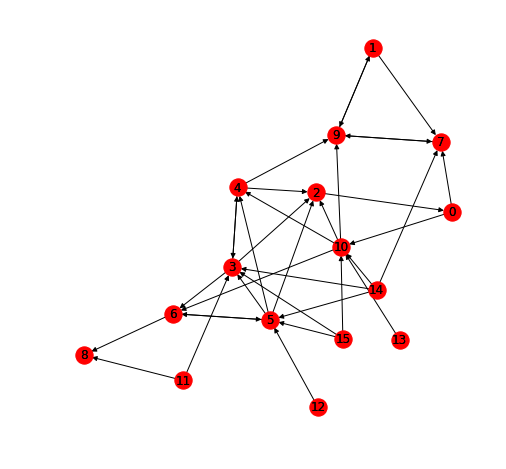

Adjacency: 0.69921875
W_out: 0.69921875
Boolean: 0.78515625


In [78]:
# Breast cell 
tlg = nn.LogicNetwork.read_logic('../data/walker/logic/breastcell_expressions.ALL.txt', 
             external_nodes_path='../data/walker/logic/breastcell_external_components.ALL.txt')
tlG = nn.LogicNetwork.to_networkx_graph(tlg)
plt.figure(figsize=(8,8))
pos = nx.kamada_kawai_layout(tlG)
nx.draw_networkx(tlG, pos)
nx.draw_networkx_labels(tlG, pos)
plt.axis('off')
plt.show()

xx = nn.LogicNetwork.to_networkx_graph(tlg, 'names')

print("Adjacency:",ns.average_sensitivity(nn.WTNetwork(nx.to_numpy_array(tlG))))
W_out_test = get_Wout_full(tlG, p0=0)
net = nn.WTNetwork(W_out_test)
print("W_out:",ns.average_sensitivity(net, states=list(net.state_space())))
print("Boolean:",ns.average_sensitivity(tlg))

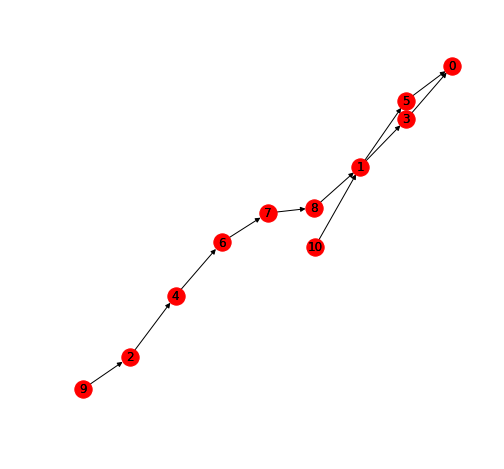

Adjacency: 0.977272727273
W_out: 0.977272727273
Boolean: 1.0


In [43]:
# Drosophila signaling pathway
tlg = nn.LogicNetwork.read_logic('../data/walker/logic/drosophila_expressions.ALL.txt', 
             external_nodes_path='../data/walker/logic/drosophila_external_components.ALL.txt')
tlG = nn.LogicNetwork.to_networkx_graph(tlg)
plt.figure(figsize=(8,8))
pos = nx.kamada_kawai_layout(tlG)
nx.draw_networkx(tlG, pos)
nx.draw_networkx_labels(tlG, pos)
plt.axis('off')
plt.show()

xx = nn.LogicNetwork.to_networkx_graph(tlg, 'names')

print("Adjacency:",ns.average_sensitivity(nn.WTNetwork(nx.to_numpy_array(tlG))))
W_out_test = get_Wout_full(tlG, p0=0)
net = nn.WTNetwork(W_out_test)
print("W_out:",ns.average_sensitivity(net, states=list(net.state_space())))
print("Boolean:",ns.average_sensitivity(tlg))

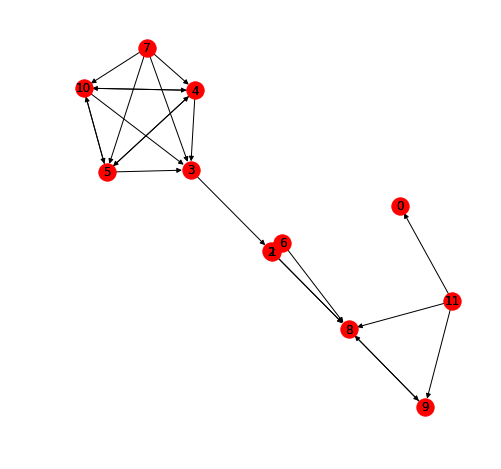

Adjacency: 0.776041666667
W_out: 0.776041666667
Boolean: 1.00520833333


In [44]:
# Metabolic Gut Microbiome
tlg = nn.LogicNetwork.read_logic('../data/walker/logic/gut_expressions.ALL.txt', 
             external_nodes_path='../data/walker/logic/gut_external_components.ALL.txt')
tlG = nn.LogicNetwork.to_networkx_graph(tlg)
plt.figure(figsize=(8,8))
pos = nx.kamada_kawai_layout(tlG)
nx.draw_networkx(tlG, pos)
nx.draw_networkx_labels(tlG, pos)
plt.axis('off')
plt.show()

xx = nn.LogicNetwork.to_networkx_graph(tlg, 'names')

print("Adjacency:",ns.average_sensitivity(nn.WTNetwork(nx.to_numpy_array(tlG))))
W_out_test = get_Wout_full(tlG, p0=0)
net = nn.WTNetwork(W_out_test)
print("W_out:",ns.average_sensitivity(net, states=list(net.state_space())))
print("Boolean:",ns.average_sensitivity(tlg))

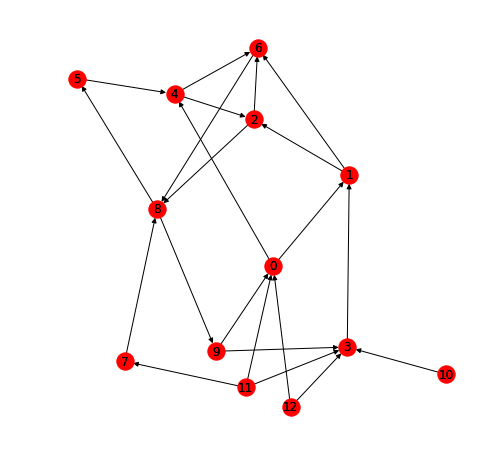

Adjacency: 0.826923076923
W_out: 0.826923076923
Boolean: 1.0


In [45]:
# Lac Operon
tlg = nn.LogicNetwork.read_logic('../data/walker/logic/lac_expressions.ALL.txt', 
             external_nodes_path='../data/walker/logic/lac_external_components.ALL.txt')
tlG = nn.LogicNetwork.to_networkx_graph(tlg)
plt.figure(figsize=(8,8))
pos = nx.kamada_kawai_layout(tlG)
nx.draw_networkx(tlG, pos)
nx.draw_networkx_labels(tlG, pos)
plt.axis('off')
plt.show()

xx = nn.LogicNetwork.to_networkx_graph(tlg, 'names')

print("Adjacency:",ns.average_sensitivity(nn.WTNetwork(nx.to_numpy_array(tlG))))
W_out_test = get_Wout_full(tlG, p0=0)
net = nn.WTNetwork(W_out_test)
print("W_out:",ns.average_sensitivity(net, states=list(net.state_space())))
print("Boolean:",ns.average_sensitivity(tlg))

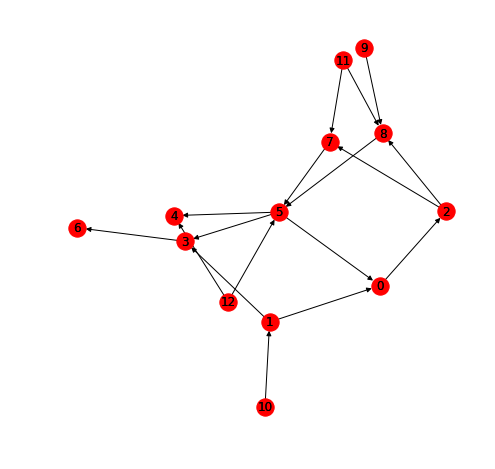

Adjacency: 0.884615384615
W_out: 0.884615384615
Boolean: 1.03846153846


In [46]:
# E-colo
tlg = nn.LogicNetwork.read_logic('../data/walker/logic/ecoli_expressions.ALL.txt', 
             external_nodes_path='../data/walker/logic/ecoli_external_components.ALL.txt')
tlG = nn.LogicNetwork.to_networkx_graph(tlg)
plt.figure(figsize=(8,8))
pos = nx.kamada_kawai_layout(tlG)
nx.draw_networkx(tlG, pos)
nx.draw_networkx_labels(tlG, pos)
plt.axis('off')
plt.show()

xx = nn.LogicNetwork.to_networkx_graph(tlg, 'names')

print("Adjacency:",ns.average_sensitivity(nn.WTNetwork(nx.to_numpy_array(tlG))))
W_out_test = get_Wout_full(tlG, p0=0)
net = nn.WTNetwork(W_out_test)
print("W_out:",ns.average_sensitivity(net, states=list(net.state_space())))
print("Boolean:",ns.average_sensitivity(tlg))

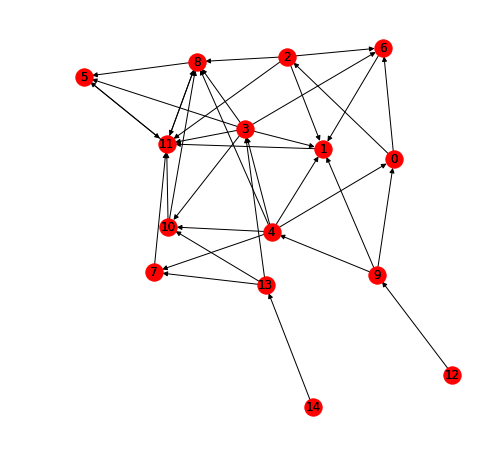

Adjacency: 0.702083333333
W_out: 0.702083333333
Boolean: 0.990625


In [47]:
# cardiac development
tlg = nn.LogicNetwork.read_logic('../data/walker/logic/cardiac_expressions.ALL.txt', 
             external_nodes_path='../data/walker/logic/cardiac_external_components.ALL.txt')
tlG = nn.LogicNetwork.to_networkx_graph(tlg)
plt.figure(figsize=(8,8))
pos = nx.kamada_kawai_layout(tlG)
nx.draw_networkx(tlG, pos)
nx.draw_networkx_labels(tlG, pos)
plt.axis('off')
plt.show()

xx = nn.LogicNetwork.to_networkx_graph(tlg, 'names')

print("Adjacency:",ns.average_sensitivity(nn.WTNetwork(nx.to_numpy_array(tlG))))
W_out_test = get_Wout_full(tlG, p0=0)
net = nn.WTNetwork(W_out_test)
print("W_out:",ns.average_sensitivity(net, states=list(net.state_space())))
print("Boolean:",ns.average_sensitivity(tlg))

In [49]:
out_dict['URL_data']

['https://cellcollective.org/#2681/cell-cycle-transcription-by-coupled-cdk-and-network-oscillators',
 'https://cellcollective.org/#2668/toll-pathway-of-drosophila-signaling-pathway',
 'https://cellcollective.org/#5731/metabolic-interactions-in-the-gut-microbiome',
 'https://cellcollective.org/#5128/lac-operon',
 'https://cellcollective.org/#6885:1/regulation-of-the-larabinose-operon-of-escherichia-coli/1',
 'https://cellcollective.org/#4837:1/arabidopsis-thaliana-cell-cycle/1',
 'https://cellcollective.org/#2136/cardiac-development',
 'https://cellcollective.org/#4790:1/fanconi-anemia-and-checkpoint-recovery/1',
 'https://cellcollective.org/#4706/predicting-variabilities-in-cardiac-gene',
 'https://cellcollective.org/#2699/bt474-breast-cell-line-shortterm-erbb-network',
 'https://cellcollective.org/#2700:1/hcc1954-breast-cell-line-shortterm-erbb-network/1',
 'https://cellcollective.org/#2202:1/neurotransmitter-signaling-pathway/1',
 'https://cellcollective.org/#2701:1/skbr3-breast-cell

In [ ]:
nn.examples.s_pombe

In [99]:
ttt = nn.WTNetwork(nx.to_numpy_array(mG).T)

In [104]:
ttt.

596

In [100]:
ns.average_sensitivity(ttt)

KeyboardInterrupt: 

In [98]:
sum([max(nx.to_numpy_array(mG)[i])!=1.0 for i in range(mG.number_of_nodes())])#.T)

20

In [172]:
transistors_df = pd.read_csv("data/transistors.csv")
transistors_df.head()

bb   c1    c2  gate name     on       x       y  pos
0  [1450, 1510, 5143, 5320]  558   217   357   t0  False  1480.0  5231.5    0
1    [5424, 5629, 548, 922]  657   349  1608   t1  False  5526.5   735.0    1
2  [3867, 3899, 2465, 2642]  558  1146   412   t2  False  3883.0  2553.5    2
3  [7907, 7990, 9237, 9311]  558   943   558   t3  False  7948.5  9274.0    3
4    [1893, 1910, 530, 927]  230   657   826   t4  False  1901.5   728.5    4

In [254]:
c1c2np = np.array(transistors_df[['c1','c2']])
c1c2el = [tuple(c1c2np[i]) for i in range(len(c1c2np))]

gac1np = np.array(transistors_df[['gate','c1']])
gac1el = [tuple(gac1np[i]) for i in range(len(gac1np))]

gac2np = np.array(transistors_df[['gate','c2']])
gac2el = [tuple(gac2np[i]) for i in range(len(gac2np))]

c1c2 = nx.from_edgelist(c1c2el)
gac1 = nx.from_edgelist(gac1el)
gac2 = nx.from_edgelist(gac2el)

In [255]:
pos = np.array(transistors_df[['x','y']])
col = np.array(transistors_df[['name']])
col_mapping = dict(zip(np.unique(col), list(range(len(np.unique(col))))))
ncol = {col_mapping[i]:col_mapping[i]/max(col_mapping.values()) for i in list(transistors_df['name'])}
# nc = plt.cm.rainbow(np.array(list(ncol.values())))
# pos = nx.kamada_kawai_layout(c1c2)

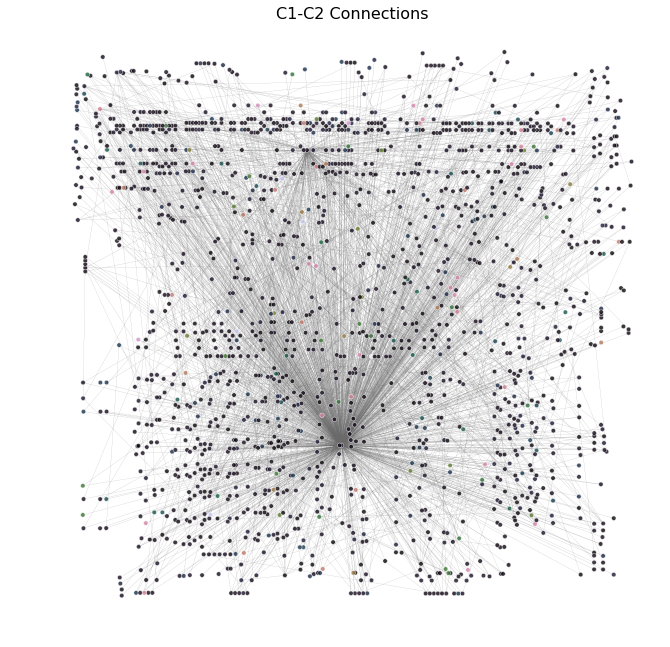

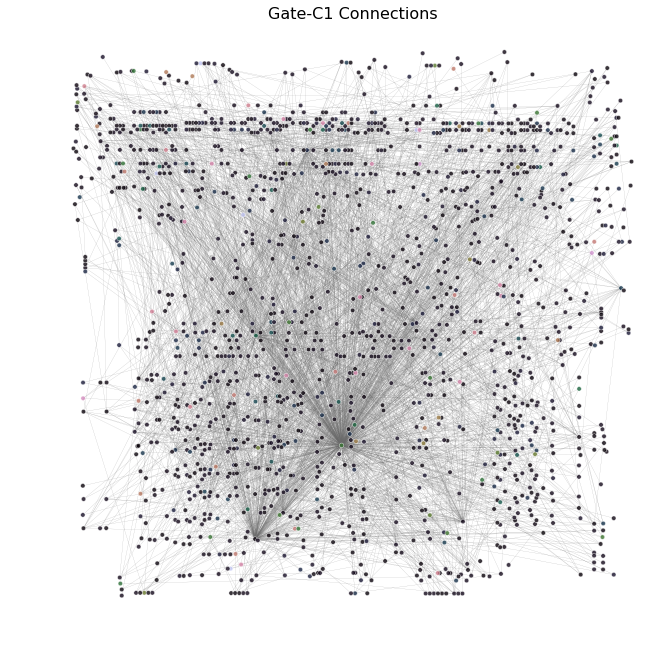

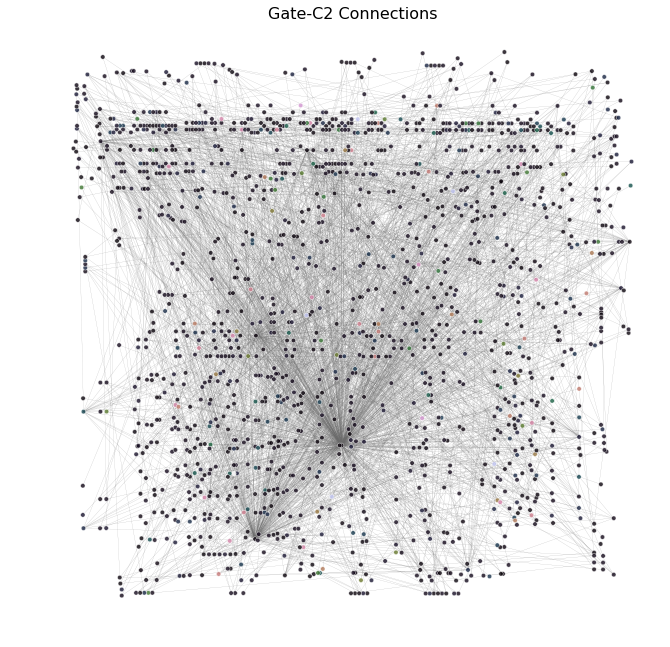

In [300]:
plt.figure(figsize=(11,11))
nx.draw_networkx_nodes(c1c2, pos, node_color=nc, node_size=20, edgecolors='w', linewidths=0.5, alpha=0.8)
nx.draw_networkx_edges(c1c2, pos, edge_color='#666666', width=0.10)
plt.title("C1-C2 Connections", size=16)
plt.axis('off')
plt.show()

plt.figure(figsize=(11,11))
nx.draw_networkx_nodes(gac1, pos, node_color=nc, node_size=20, edgecolors='w', linewidths=0.5, alpha=0.8)
nx.draw_networkx_edges(gac1, pos, edge_color='#666666', width=0.10)
plt.title("Gate-C1 Connections", size=16)
plt.axis('off')
plt.show()

plt.figure(figsize=(11,11))
nx.draw_networkx_nodes(gac2, pos, node_color=nc, node_size=20, edgecolors='w', linewidths=0.5, alpha=0.8)
nx.draw_networkx_edges(gac2, pos, edge_color='#666666', width=0.10)
plt.title("Gate-C2 Connections", size=16)
plt.axis('off')
plt.show()

In [258]:
transistors_df = pd.read_csv("data/transistors.csv")
transistors_df.head()

bb   c1    c2  gate name     on       x       y  pos
0  [1450, 1510, 5143, 5320]  558   217   357   t0  False  1480.0  5231.5    0
1    [5424, 5629, 548, 922]  657   349  1608   t1  False  5526.5   735.0    1
2  [3867, 3899, 2465, 2642]  558  1146   412   t2  False  3883.0  2553.5    2
3  [7907, 7990, 9237, 9311]  558   943   558   t3  False  7948.5  9274.0    3
4    [1893, 1910, 530, 927]  230   657   826   t4  False  1901.5   728.5    4

In [385]:
ws = []
for i in range(len(transistors_df)):
    bb = transistors_df['bb'][i]
    bb = ast.literal_eval(bb)
    widths = bb[1]-bb[0]
    height = bb[3]-bb[2]
    ws.append(widths*height)

In [440]:
col = [(ws[i]+20000)/(max(ws)*1.2) for i in range(len(ws))]
# col = [(ws[i]+80000)/(max(ws)*1.6) for i in range(len(ws))]
nc = plt.cm.gist_ncar(np.array(col))

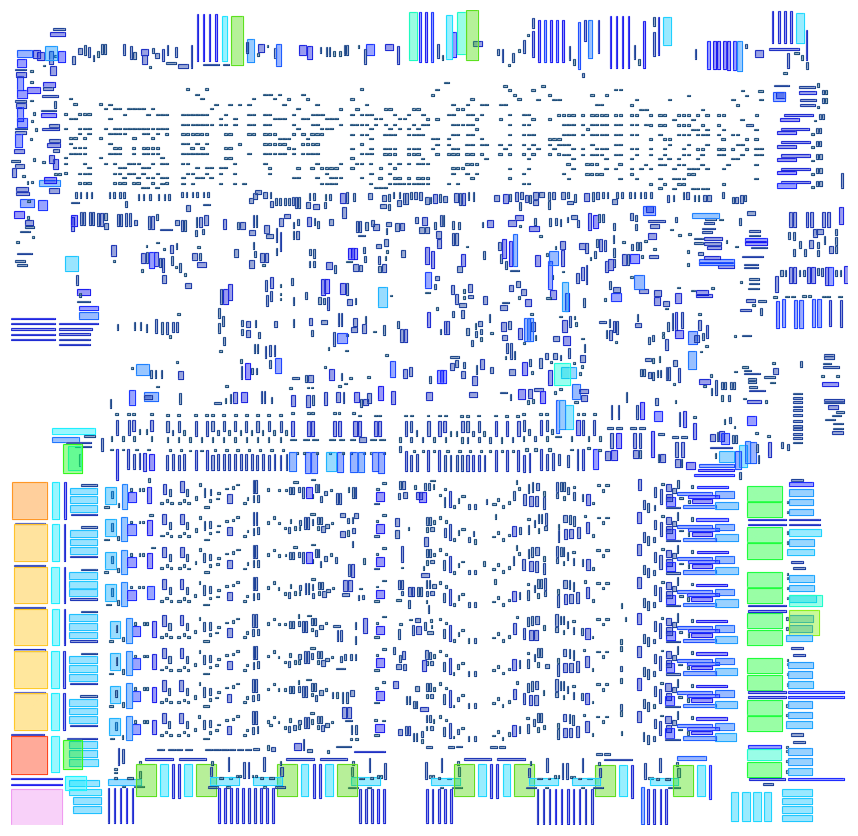

In [450]:
fig, ax = plt.subplots(1, figsize=(15,15))

# Create a Rectangle patch
xmin_bb = 4000
xmax_bb = 4000
ymin_bb = 4000
ymax_bb = 4000
for i in range(len(transistors_df)):
    bb = transistors_df['bb'][i]
    bb = ast.literal_eval(bb)
    if bb[1] > xmax_bb:
        xmax_bb = bb[1]
    if bb[0] < xmin_bb:
        xmin_bb = bb[0]
    if bb[3] > ymax_bb:
        ymax_bb = bb[3]
    if bb[2] < ymin_bb:
        ymin_bb = bb[2]
    rect = patches.Rectangle((bb[0],bb[2]),bb[1]-bb[0],bb[3]-bb[2], 
                             linewidth=1.15, edgecolor=nc[i],facecolor='none')
    ax.add_patch(rect)

    rect = patches.Rectangle((bb[0],bb[2]),bb[1]-bb[0],bb[3]-bb[2], 
                             linewidth=0, edgecolor='none',facecolor=nc[i], alpha=0.6)
    ax.add_patch(rect)
    
    rect = patches.Rectangle((bb[0],bb[2]),bb[1]-bb[0],bb[3]-bb[2], 
                             linewidth=0.25, edgecolor='w',facecolor='none')
    ax.add_patch(rect)

nx.draw_networkx_edges(c1c2, pos, edge_color='w', width=0.10, alpha=0.6)
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')
plt.xlim(xmin_bb-1,xmax_bb+1)
plt.ylim(ymin_bb-1,ymax_bb+1)
plt.axis('off')

# plt.savefig("figs/pngs/MicroProcessor0.png", dpi=425, bbox_inches='tight', facecolor='#262626')
# plt.savefig("figs/pdfs/MicroProcessor0.pdf", dpi=425, bbox_inches='tight', facecolor='#262626')
plt.savefig("figs/pngs/MicroProcessor1.png", dpi=425, bbox_inches='tight', facecolor='#262626')
plt.savefig("figs/pdfs/MicroProcessor1.pdf", dpi=425, bbox_inches='tight', facecolor='#262626')

plt.show()

In [ ]:
G = nx.read_gml('data/9.gml')
print("degen:", np.round(get_degeneracy(G)/np.log2(G.number_of_nodes()), 5), 
      "\ndeter:", np.round(get_determinism(G)/np.log2(G.number_of_nodes()), 5), 
      "\neffin:", np.round(get_ei(G)/np.log2(G.number_of_nodes()), 5))
print("degen:", np.round(get_degeneracy(G), 5), 
      "\ndeter:", np.round(get_determinism(G), 5), 
      "\neffin:", np.round(get_ei(G), 5))

plt.figure(figsize=(10,10))
nx.draw_kamada_kawai(G, node_color='dodgerblue', node_size=150, edge_width=2.0, edge_color='grey')
plt.show()

G = nx.convert_node_labels_to_integers(G)

partition = community.best_partition(nx.to_undirected(G))
comms = np.array([partition[i] for i in G.nodes()])
node_colors_co = [colors[i] for i in comms]
dorm_lists = assignmentArray_to_lists(partition)
nodes_dorm_ordered = [node for dorm in dorm_lists for node in dorm]

draw_adjacency_matrix(G, nodes_dorm_ordered, [dorm_lists], ["dodgerblue"])